In [104]:
import numpy as np
import torch
import torch.nn as nn
from torch_scatter import scatter_mean
import itertools
from torch_geometric.data import Dataset, Data, DataLoader

In [105]:
n_features=48
n_tracks=10
n_samples=2000+500
x_idx=0
y_idx=3

In [106]:
# generate irrelevant input
X=torch.normal(mean=torch.zeros(n_samples*n_tracks,n_features),std=torch.ones(n_samples*n_tracks,n_features),)
X_batch=torch.arange(n_samples).repeat_interleave(n_tracks)

In [107]:
# generate relevant input
x=torch.randint(0,2,(n_samples*n_tracks,))*10
y=torch.randint(-2,2,(n_samples*n_tracks,))*10

X[:,x_idx]+=x
X[:,y_idx]+=y

# graph label is sign(mean(x+2y))
label=torch.sign(scatter_mean(x+2*y,X_batch))
label[label<0]=0
temp=torch.zeros(n_samples,2)
temp[:,1]=label
temp[label==0,0]=1
label=temp

In [108]:
# class ratio
(label[:,1]>0).sum()/float(n_samples),(label[:,0]>0).sum()/float(n_samples)

(tensor(0.2420), tensor(0.7580))

In [109]:
# with pertubation
temp=torch.sign(scatter_mean(X[:,x_idx]+2*X[:,y_idx],X_batch))
temp[temp<0]=0

In [110]:
(temp==label[:,1]).sum()/float(n_samples)

tensor(0.9732)

In [112]:
label[:10],X[0:10,:].shape

(tensor([[0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.]]),
 torch.Size([10, 48]))

In [125]:
# make graphs
pairs=np.stack([[m, n] for (m, n) in itertools.product(range(n_tracks),range(n_tracks)) if m!=n])
edge_index=torch.tensor(pairs, dtype=torch.long)
edge_index=edge_index.t().contiguous()

datas=[]
for i in range(n_samples):
    start_idx,end_idx=i*10,i*10+10
    data=Data(x=X[start_idx:end_idx,:], edge_index=edge_index, y=label[i].view(1,2))
    data.u=None

    datas.append(data)
    
# split into test and train
train_data=datas[:2000]
test_data=datas[2000:]

# save to file
torch.save(train_data, "../data/train_sytehsized.pt")
torch.save(test_data, "../data/test_sytehsized.pt")

In [126]:
train_data[0]

Data(edge_index=[2, 90], x=[10, 48], y=[1, 2])

<hr>

In [127]:
train_data=torch.load("../data/train_sytehsized.pt")
test_data=torch.load("../data/test_sytehsized.pt")

training model on sythesized data

In [128]:
from InteractionNetwork import InteractionNetwork
from tqdm.notebook import tqdm

In [129]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model=InteractionNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)


In [133]:
@torch.no_grad()
def test(model,loader,total,batch_size,leave=False):
    model.eval()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)


def train(model, optimizer, loader, total, batch_size,leave=False):
    model.train()
    
    xentropy = nn.CrossEntropyLoss(reduction='mean')

    sum_loss = 0.
    t = tqdm(enumerate(loader),total=total/batch_size,leave=leave)
    for i,data in t:
        data = data.to(device)
        y = torch.argmax(data.y,dim=1)
        optimizer.zero_grad()
        batch_output = model(data.x, data.edge_index, data.batch)
        batch_loss = xentropy(batch_output, y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [134]:
from torch_geometric.data import Batch
from torch.utils.data import random_split


torch.manual_seed(0)
valid_frac = 0.20
full_length = len(train_data)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(train_data, [full_length-valid_num,valid_num])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, pin_memory=True, shuffle=False)


test_samples = len(test_data)
train_samples = len(train_dataset)
valid_samples = len(valid_dataset)

In [138]:
n_epochs = 10
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size,leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size,leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = '../data/model/IN_sythesized.pth'
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

Epoch: 00, Training Loss:   0.0586
           Validation Loss: 0.1956
New best model saved to: ../data/model/IN_sythesized.pth


Epoch: 01, Training Loss:   0.0592
           Validation Loss: 0.2819
Stale epoch


Epoch: 02, Training Loss:   0.1034
           Validation Loss: 0.1660
New best model saved to: ../data/model/IN_sythesized.pth


Epoch: 03, Training Loss:   0.0813
           Validation Loss: 0.2299
Stale epoch


Epoch: 04, Training Loss:   0.0462
           Validation Loss: 0.2531
Stale epoch


Epoch: 05, Training Loss:   0.0473
           Validation Loss: 0.2265
Stale epoch


Epoch: 06, Training Loss:   0.0343
           Validation Loss: 0.1963
Stale epoch


Epoch: 07, Training Loss:   0.0326
           Validation Loss: 0.2640
Stale epoch
Early stopping after 5 stale epochs



In [139]:
model.eval()
t = tqdm(enumerate(test_loader),total=500/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data.x, data.edge_index, data.batch)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

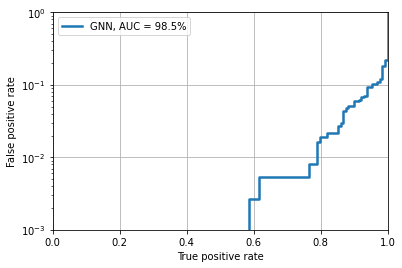

In [140]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()